## CLIPでの主観的価値の推定

In [1]:
import numpy as np
import torch
import clip
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
import os
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm

from sklearn.linear_model import Ridge
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform, pearsonr

from src.const import DATA_PATH

plt.rcParams["font.serif"] = ["noto"]

In [2]:
resp = pd.read_csv(os.path.join(DATA_PATH, "data_responses_NCNP_2types.csv"))
food_value = pd.read_csv(os.path.join(DATA_PATH, "food_value.csv"))


In [3]:
resp["is_obesity"] = resp["BMI"] >= 25

In [4]:
outlier = resp["sub_ID"].unique()[
        (resp.groupby("sub_ID")["res_L"].value_counts().unstack() > 896 * 0.75).any(
            axis=1
        )
        | (
            (resp.groupby("sub_ID")["res_L"].unique().apply(lambda x: len(x)) <= 4)
            & (
                resp.groupby("sub_ID")["res_L"].value_counts().unstack() > 896 * 0.65
            ).any(axis=1)
        )
    ]
print("被験者", outlier, len(outlier), "人を除外")
res_L_mean = (
    resp.groupby(["img", "is_obesity"])["res_L"].mean()
)
res_H_mean = (
    resp.groupby(["img", "is_obesity"])["res_H"].mean()
)
res_T_mean = (
    resp.groupby(["img", "is_obesity"])["res_T"].mean()
)
res_L_mean

被験者 [ 50  83 104 121 130 137 138 143 147 150] 10 人を除外


img  is_obesity
1    False         5.945455
     True          5.853933
2    False         6.190909
     True          6.438202
3    False         6.118182
                     ...   
894  True          4.460674
895  False         4.209091
     True          3.258427
896  False         5.581818
     True          4.752809
Name: res_L, Length: 1792, dtype: float64

In [5]:
class ImageDataset(Dataset):
    def __init__(self, image_dir: str, label_series: pd.Series, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.image_files = sorted(
            [f for f in os.listdir(image_dir) if f.endswith(".jpg")]
        )
        self.label_series = label_series

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # print(idx)
        img_name = os.path.join(self.image_dir, self.image_files[idx])
        image = Image.open(img_name).convert("RGB")
        if self.transform:
            image = self.transform(image)
        else:
            image = transforms.ToTensor()(image)

        # Replace 0 with actual label if available
        label = self.label_series[idx]

        return image, label


In [6]:
# device = "cuda" if torch.cuda.is_available() else "cpu"
device ="cpu"
model, preprocess = clip.load("RN50x4", device=device)
# model, preprocess = clip.load("ViT-B/16", device=device)

In [7]:
from src.const import ROOT_PATH
from torchvision.transforms import v2
# from torchvision.transforms import InterpolationMode

image_dir = os.path.join(ROOT_PATH, "Database")
# transform = transforms.Compose(
#     [
#         transforms.ToTensor(),
#         v2.Resize((224, 224), interpolation=InterpolationMode.BICUBIC),
#         v2.ToDtype(torch.float32, scale=True),
#         v2.Normalize(
#             [0.48145466, 0.4578275, 0.40821073], [0.26862954, 0.26130258, 0.27577711]
#         ),
#     ]
# )
dataset = ImageDataset(
    image_dir=image_dir,
    label_series=food_value["Item_description"],
    transform=preprocess
)

In [8]:
image_brightness = []
for image, label in tqdm(
    ImageDataset(
        image_dir=image_dir,
        label_series=food_value["Item_description"],
        # transform=preprocess,
    )
):
    image_brightness.append(image.mean().item())
image_brightness = pd.Series(
    image_brightness,
    name="brightness",
    index=pd.Series([False] * len(image_brightness), name="is_obesity"),
)

100%|██████████| 896/896 [00:19<00:00, 45.28it/s]


In [9]:
from src.eda import save_intermediate_activations, register_hooks, save_layer_matrixs

# layer_num = register_hooks(model)
# print(layer_num)
save_dir = os.path.join(
    ROOT_PATH,
    "tmp",
    "clip",
    "intermediate_feature",
)
layer_num = 81
save_intermediate_activations(model, dataset, save_dir, device)
save_layer_matrixs(save_dir, layer_num)


train transforms:
resize 240x240
↓
center crop 224x224
↓
random horizontal flip
↓
random affine degrees=20, translate=(0.2, 0.2), scale=(0.7, 1.2), fill=(255, 255, 255)
↓
gaussian blur kernel_size=(5, 5), sigma=(0.1, 3)
↓
color jitter brightness=0.075, contrast=0, saturation=0.03, hue=0.03
↓
to tensor
↓
visual
conv1
bn1
relu1
Registered hook on: relu1
conv2
bn2
relu2
Registered hook on: relu2
conv3
bn3
relu3
Registered hook on: relu3
avgpool
layer1
0
conv1
bn1
relu1
Registered hook on: relu1
conv2
bn2
relu2
Registered hook on: relu2
avgpool
conv3
bn3
relu3
Registered hook on: relu3
downsample
-1
0
1
1
conv1
bn1
relu1
Registered hook on: relu1
conv2
bn2
relu2
Registered hook on: relu2
avgpool
conv3
bn3
relu3
Registered hook on: relu3
2
conv1
bn1
relu1
Registered hook on: relu1
conv2
bn2
relu2
Registered hook on: relu2
avgpool
conv3
bn3
relu3
Registered hook on: relu3
3
conv1
bn1
relu1
Registered hook on: relu1
conv2
bn2
relu2
Registered hook on: relu2
avgpool
conv3
bn3
relu3
Registered 

100%|██████████| 896/896 [02:12<00:00,  6.79it/s]


torch.Size([896, 40, 144, 144])
torch.Size([896, 40, 144, 144])
torch.Size([896, 80, 144, 144])
torch.Size([896, 80, 72, 72])
torch.Size([896, 80, 72, 72])
torch.Size([896, 320, 72, 72])
torch.Size([896, 80, 72, 72])
torch.Size([896, 80, 72, 72])
torch.Size([896, 320, 72, 72])
torch.Size([896, 80, 72, 72])
torch.Size([896, 80, 72, 72])
torch.Size([896, 320, 72, 72])
torch.Size([896, 80, 72, 72])
torch.Size([896, 80, 72, 72])
torch.Size([896, 320, 72, 72])
torch.Size([896, 160, 72, 72])
torch.Size([896, 160, 72, 72])
torch.Size([896, 640, 36, 36])
torch.Size([896, 160, 36, 36])
torch.Size([896, 160, 36, 36])
torch.Size([896, 640, 36, 36])
torch.Size([896, 160, 36, 36])
torch.Size([896, 160, 36, 36])
torch.Size([896, 640, 36, 36])
torch.Size([896, 160, 36, 36])
torch.Size([896, 160, 36, 36])
torch.Size([896, 640, 36, 36])
torch.Size([896, 160, 36, 36])
torch.Size([896, 160, 36, 36])
torch.Size([896, 640, 36, 36])
torch.Size([896, 160, 36, 36])
torch.Size([896, 160, 36, 36])
torch.Size([8

Processing Layers: 100%|██████████| 81/81 [05:26<00:00,  4.03s/it] 


In [10]:
VERSION = "v2"
image_features_list = []

for image, label in tqdm(dataset):
    image = image.unsqueeze(0).to(device)
    with torch.no_grad():
        image_features = model.encode_image(image)
    image_features_list.append(image_features)

image_features = torch.cat(image_features_list)
print(image_features.shape)
torch.save(image_features, os.path.join(DATA_PATH, "output", "clip", VERSION, "image_features.pt"))
image_features = torch.load(
    os.path.join(DATA_PATH, "output", "clip", VERSION, "image_features.pt")
)


100%|██████████| 896/896 [04:33<00:00,  3.28it/s]


torch.Size([896, 640])


In [11]:
# ridge regression
from sklearn.discriminant_analysis import StandardScaler
from sklearn.model_selection import KFold, cross_val_score


def pearson_scorer(y_true, y_pred):
    corr, _ = pearsonr(y_true, y_pred)
    return np.mean(corr)


image_dir = os.path.join(ROOT_PATH, "Database")
pearson_sklearn = make_scorer(pearson_scorer, greater_is_better=True)
X = image_features.cpu().numpy()
h = 5
skf = StratifiedKFold(n_splits=h, shuffle=True, random_state=1)
kf = KFold(n_splits=h, shuffle=True, random_state=3)

# pca = make_pipeline(StandardScaler(), PCA(n_components=0.98))
# X = pca.fit_transform(image_features.cpu().numpy())
result = {}
for i, res in enumerate([res_L_mean, res_H_mean, res_T_mean, image_brightness]):
    result[res.name] = {
        "obesity": {
            "y_tests": [],
            "y_preds": [],
        },
        "normal": {
            "y_tests": [],
            "y_preds": [],
        },
    }
    for is_obesity, y in res.groupby("is_obesity"):
        y = y.groupby("img").mean() if res.name != "brightness" else res
        # dataset = ImageDataset(image_dir, y)
        labels = y.values
        # n_bins = 8  # ビンの数（例: 4つのカテゴリに分割）
        # bins = np.linspace(1, 8, n_bins + 1)  # ビンの境界を定義
        # binned_labels = np.digitize(labels, bins) - 1
        # normal_score = 0
        # if not is_obesity:
        #     normal_score_list = []
        pbar = tqdm(
            # enumerate(skf.split(np.zeros(len(binned_labels)), binned_labels)),
            enumerate(kf.split(np.zeros(len(labels)), labels)),
            total=h,
            leave=False,
        )
        type = "obesity" if is_obesity else "normal"
        for j, (train_idx, val_idx) in pbar:
            # Train and validation subsets
            print(y.name)
            # print("肥満" if is_obesity else "健常")
            print(len(y))
            X_train, X_test = X[train_idx], X[val_idx]
            y_train, y_test = labels[train_idx], labels[val_idx]
            ridge = make_pipeline(Ridge(alpha=1.0))
            # random search
            # param_distributions = {"ridge__alpha": loguniform(1e-3, 1e3)}

            # search = RandomizedSearchCV(
            #     ridge,
            #     param_distributions,
            #     n_iter=20,
            #     cv=5,
            #     n_jobs=4,
            #     random_state=42,
            #     scoring=pearson_sklearn,
            # )

            ridge.fit(X_train, y_train)
            # scores = cross_val_score(ridge, X, labels, cv=5, scoring=pearson_sklearn)
            # print(np.mean(scores))
            # print(ridge.best_params_)
            # print("best score", search.best_score_)
            # best_model = search.best_estimator_
            y_pred = ridge.predict(X_test)
            result[res.name][type]["y_preds"].append(
                y_pred
            )
            result[res.name][type]["y_tests"].append(
                y_test
            )
        print(np.mean([pearson_scorer(
                    y_test,
                    result[res.name][type]["y_preds"][i],
                ) for i, y_test in enumerate(result[res.name][type]["y_tests"])]))


res_L
896
res_L
896
res_L
896
res_L
896
res_L
896
0.761140175559845


res_L
896
res_L
896
res_L
896
res_L
896
res_L
896
0.7686977739169178


 80%|████████  | 4/5 [00:00<00:00, 33.02it/s]

res_H
896
res_H
896
res_H
896
res_H
896
res_H
896


0.9447303970908194


  0%|          | 0/5 [00:00<?, ?it/s]

res_H
896
res_H
896


res_H
896
res_H
896
res_H
896
0.9454500281283005


  0%|          | 0/5 [00:00<?, ?it/s]

res_T
896
res_T
896
res_T
896
res_T
896


res_T
896
0.781908708880003


  0%|          | 0/5 [00:00<?, ?it/s]

res_T
896
res_T
896


 40%|████      | 2/5 [00:00<00:00, 19.24it/s]

res_T
896
res_T
896


res_T
896
0.7933738208091705


  0%|          | 0/5 [00:00<?, ?it/s]

brightness
896
brightness
896
brightness
896
brightness
896
brightness
896


0.9021647057589783


In [12]:
for i, (name, value) in enumerate(result.items()):
    if name == "brightness":
        continue
    print(name)
    for type in value.keys():
        print(type)
        y_dict = value[type]
        # print(name, y_dict)
        y_test = np.concatenate(y_dict["y_tests"])
        y_pred = np.concatenate(y_dict["y_preds"])
        score = pearson_scorer(y_test, y_pred)
        # if 
        print(score)

res_L
obesity
0.7684547336859888
normal
0.7618761837829687
res_H
obesity
0.9449238432506402
normal
0.9439852956819387
res_T
obesity
0.7925067717906499
normal
0.7834088901487058


res_L
0.231 0.762
res_H
0.345 0.944
res_T
0.251 0.783
brightness
0.001 0.901


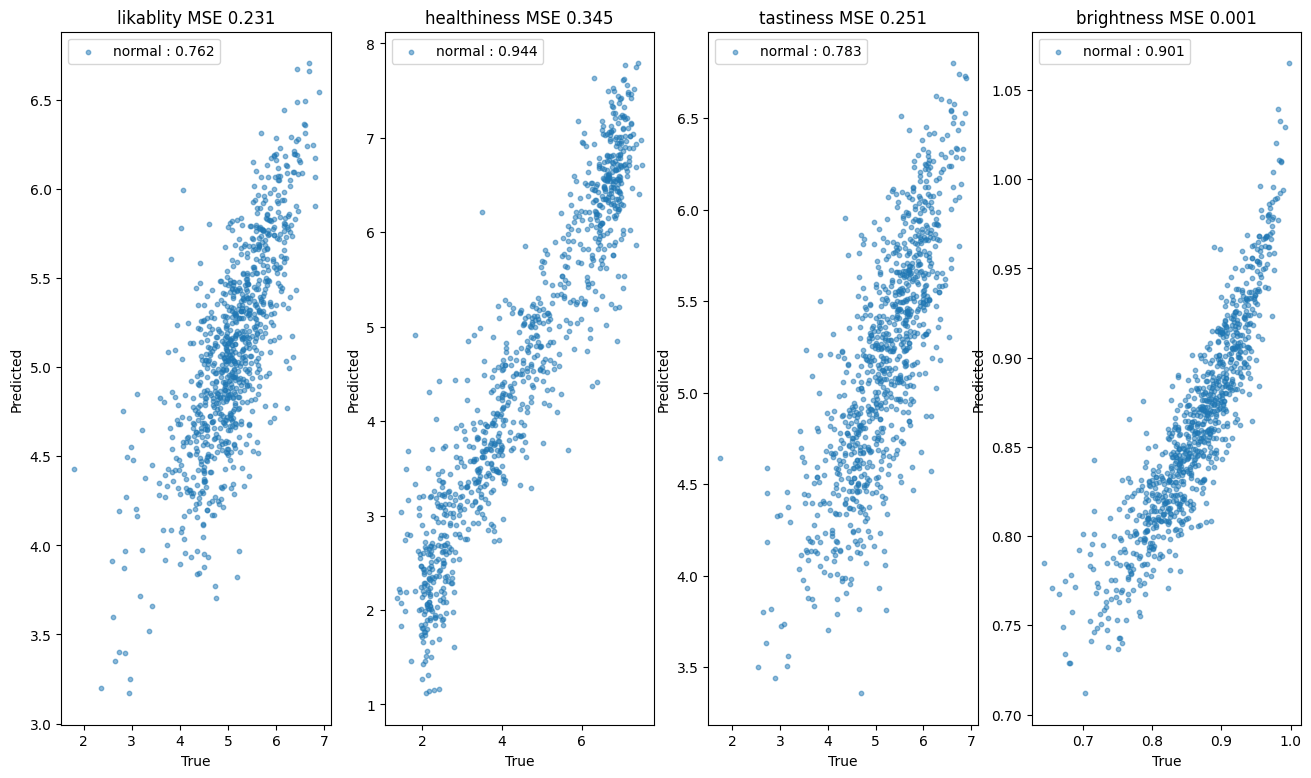

In [13]:
import pickle


fig, axes = plt.subplots(1, 4, figsize=(16, 9))
for i, (name, value) in enumerate(result.items()):
    print(name)
    labels = []
    # if name == "res_L":
    #     with open(os.path.join(DATA_PATH, "output", "clip_res_L_score_v2.pkl"), "wb") as f:
    #         pickle.dump(
    #             {
    #                 "obesity": {
    #                     "y_tests": value["obesity"]["y_tests"],
    #                     "y_preds": value["obesity"]["y_preds"],
    #                     "score": pearson_scorer(
    #                         np.concatenate(value["obesity"]["y_tests"]),
    #                         np.concatenate(value["obesity"]["y_preds"]),
    #                     ),
    #                 },
    #                 "normal": {
    #                     "y_tests": value["normal"]["y_tests"],
    #                     "y_preds": value["normal"]["y_preds"],
    #                     "score": pearson_scorer(
    #                         np.concatenate(value["normal"]["y_tests"]),
    #                         np.concatenate(value["normal"]["y_preds"]),
    #                     ),
    #                 },
    #             },
    #             f,
    #         )
    # for type_name, y_dict in value.items():
    # if name == "brightness" and type_name == "obesity":
    #     continue
    y_dict = value["normal"]
    y_test = np.concatenate(y_dict["y_tests"])
    y_pred = np.concatenate(y_dict["y_preds"])
    score = pearson_scorer(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    labels.append(f"normal : {round(score, 3)}")

    axes[i].scatter(
        y_test,
        y_pred,
        label=f"{name}_{'健常'}",
        alpha=0.5,
        s=10,
    )
    handle, _ = axes[i].get_legend_handles_labels()

    axes[i].legend(
        handle,
        labels,
        loc="upper left",
    )
    axes[i].set_xlabel("True")
    axes[i].set_ylabel("Predicted")
    # if y.name == "brightness":
    #     axes[i].set_xticks(
    #         np.arange(
    #             round(y_test.min() - 0.1, 2), round(y_test.max() + 0.1, 2), 0.1
    #         )
    #     )
    #     axes[i].set_yticks(
    #         np.arange(
    #             round(y_test.min() - 0.1, 2), round(y_test.max() + 0.1, 2), 0.1
    #         )
    #     )
    # else:
    #     axes[i].set_xticks(np.arange(1, 9, 1))
    #     axes[i].set_yticks(np.arange(1, 9, 1))
    print(round(mse, 3), round(score, 3))

    match name:
        case "res_L":
            title = "likablity"
        case "res_H":
            title = "healthiness"
        case "res_T":
            title = "tastiness"
        case "brightness":
            title = "brightness"
    axes[i].set_title(title + " MSE " + str(round(mse, 3)))
plt.show()
